# Tutorial: Maximum Cut via Quantum Imaginary Time Evolution (QITE)
## By: Willie Aboumrad, Senior Quantum Applications Scientist at IonQ

Quantum computers are poised to solve problems that are currently intractable,
and IonQ is leading the way. In this tutorial, we demonstrate how to leverage
[IonQ Forte][1]'s industry-leading capabilities to solve instances of the
[NP-hard][2] combinatorial optimization problem known as
[Maximum Cut (MaxCut)][3] using a
[novel Variational Quantum Imaginary Time Evolution (varQITE)][4] algorithm
developed by IonQ in conjunction with researchers at Oak Ridge National Labs
(ORNL).

[1]: https://ionq.com/forte
[2]: https://en.wikipedia.org/wiki/NP-hardness
[3]: https://en.wikipedia.org/wiki/Maximum_cut
[4]: https://arxiv.org/pdf/2404.16135

## What's the problem? 
### MaxCut 101

The Maximum Cut Problem (MaxCut) is a classic combinatorial optimization
problem commonly used as an algorithm benchmark by scientific computing
researchers. It has numerous applications in a variety of fields: for example,
it is used in circuit desing as part of Very Large Scale Integration (VLSI) to
find the optimal layout of circuit components; it is used in the study of
social networks to identify communities; it is used in computer vision for
image segmentation, etc.

# TODO: add some reference links here

MaxCut is a graph problem: given a graph $G = (V, E)$ with vertex set $V$ and
edge set $E$, it asks for a partition of $V$ into sets $S$ and $T$ maximizing
the number of edges crossing between $S$ and $T$.

The code cell below illustrates a simple graph with four vertices and five
edges.

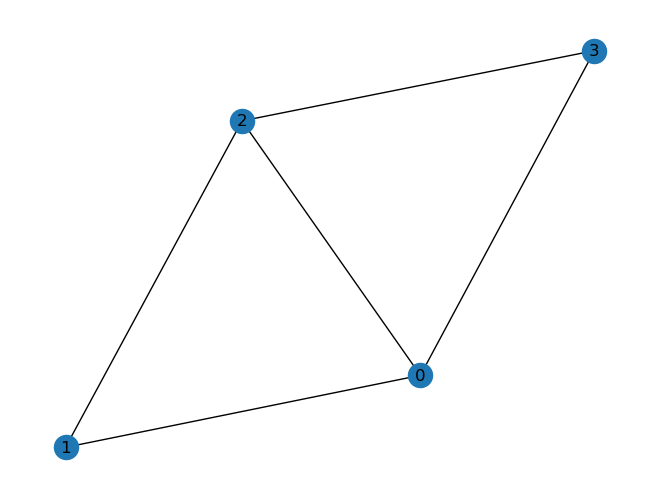

In [1]:
import networkx as nx

# Construct your favorite graph using NetworkX
edges = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
graph = nx.Graph()
graph.add_edges_from(edges)

# Fix node positions
pos = nx.spring_layout(graph)
nx.draw(graph, labels={node: node for node in graph.nodes}, pos=pos)

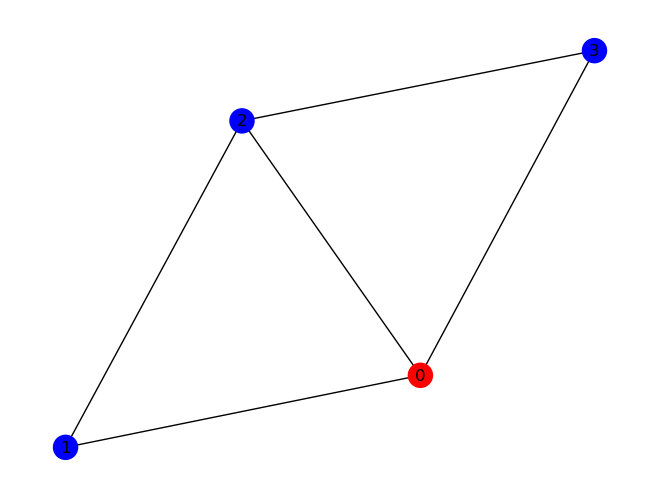

In [2]:
import numpy as np
from qiskit_optimization.applications import Maxcut

# Construct a Maxcut model
quantum_maxcut = Maxcut(graph)

# Illustrate example cuts: vertex 0 on one hand and vertices 1, 2, 3 on the other
partition = np.array([0, 1, 1, 1])
quantum_maxcut.draw(partition, pos=pos)

Formally, we write MaxCut as a [Quadratic Program (QP)][5] with binary
decision variables as follows. For each node $v \in V$, we let $x_v$ denote
a binary variable indicating whether $v$ belongs to $S$ or $T$. The objective
is to maximize the number of cut edges:
$$
    \text{maximize}_x\quad \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$

Let's break this down. Notice that for each edge $e = (v, w)$ in the graph,
the quantity $(x_v + x_w - 2 x_v x_w)$ indicates whether $e$ is *cut* by the
partition represented by $x$; that is, the quantity $(x_v + x_w - 2 x_v x_w)$
is zero or one, and it equals one only if $v$ and $w$ lie on different sides of
the partition specified by $x$.

The code cell below obtains a symbolic representation of the maximization
objective corresponding to the graph above.

[5]: https://en.wikipedia.org/wiki/Quadratic_programming

In [42]:
import sympy

# Get a variable for each node in the graph
x = sympy.symarray("x", graph.number_of_nodes())

# Get an indicator to determine whether each edge is cut
objective = sum(x[v] + x[w] - 2 * x[v] * x[w] for v, w in graph.edges)
print("Maxcut objective:")
objective

Maxcut objective:


-2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 + 3*x_0 - 2*x_1*x_2 + 2*x_1 - 2*x_2*x_3 + 3*x_2 + 2*x_3

## As a Hamiltonian energy minimization problem
### Quantum MaxCut

Quantum computers are good at finding the ground state of particle systems
evolving under the action of a given Hamiltonian. In this section, we'll
construct a Hamiltonian whose energies are exactly the values of the MaxCut
objective function. This correspondence will effectively translate our
classical combinatorial optimization problem into a quantum problem, which
we'll approach using our novel heuristic.

Given an objective function $C(x)$, with domain $x \in \{0, 1\}^n$, we'll
produce a Hamiltonian $H_C$ on $n$ qubits such that
$$
    H_C \ket{x} = C(x) \ket{x}.
$$
In the last equation, $\ket{x}$ denotes the $n$-qubit
[computational basis][10] state indexed by the bit-string $x \in \{0, 1\}$.
Thus the last equation says each of the $2^n$ computational basis states is an
eigenvector of $H_C$, and the eigenvalue corresponding to $\ket{x}$ is $C(x)$;
that is, $H_C$ is diagonal with respect to the computational basis, and its
energies are the values of the objective function $C$.

We'll obtain the Hamiltonian $H_C$ by replacing each $x_j$ in the expression of
$C(x)$ by the operator
$$
    \hat{X}_j \coloneqq \frac{1}{2}(I - Z_j),
$$
where $I$ denotes the identity operator on $n$ qubits and $Z_j$ denotes the
[Pauli-Z][11] operator acting on the $j$th qubit. Notice that $\hat{X}_j$ is
diagonal with respect to the computational basis, and its eigenvalues are zero
and one; in particular,
$$
    \hat{X}_j \ket{x} = x_j \ket{x}.
$$

### MaxCut Hamiltonian

When we apply the Ising map construction to the MaxCut objective
$$
    M(x) = \sum_{(v, w) \in E} (x_v + x_w - 2 x_v x_w)
$$
we obtain the Hamiltonian
$$
    H_M = \sum_{(v, w) \in E} (X_v + X_w - 2 X_v X_w) 
    = \frac{1}{2} \sum_{(v, w) \in E} \big(2 I - Z_v - Z_w - (I - Z_v)(I - Z_w)\big)
    = \frac{1}{2}|E| - \frac{1}{2} \sum_{(v, w) \in E} Z_v Z_w.
$$
In the last equation, $|E|$ denotes the number of edges in the graph.

The code cell below illustrates the construction of the MaxCut Hamiltonian, via
the Ising map, corresponding to a simple graph.

[10]: https://en.wikipedia.org/wiki/Qubit#Standard_representation
[11]: https://en.wikipedia.org/wiki/Pauli_matrices

In [53]:
from qiskit.quantum_info import SparsePauliOp

# Compute the MaxCut Hamiltonian
paulis = [("ZZ", [v, w], -1/2) for v, w in graph.edges]
maxcut_ham = SparsePauliOp.from_sparse_list(paulis, num_qubits=graph.number_of_nodes())
maxcut_ham += 1/2 * graph.number_of_edges() * SparsePauliOp("I" * graph.number_of_nodes())
print("Maxcut Hamiltonian:", maxcut_ham)

Maxcut Hamiltonian: SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII', 'IIII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,  2.5+0.j])


## Energy minimization via QITE
### Enter varQITE

With the MaxCut Hamiltonian in hand, we can turn to minimizing its energy using
our [novel quantum-classical varQITE heuristic][1]. Much like any Variataional
Quantum Algorithm (VQA), our novel varQITE method provides a recipe for
iteratively updating the parameters in a variational quantum circuit to
minimize the expectation value of the MaxCut Hamiltonian, measured with respect
to the parametrized state.

A key novelty is that our varQITE algorithm does *not* rely on a classical
optimizer to update the circuit parameters; instead, it specifies an explicit
update rule based on the solution of a system linear Ordinary Differential
Equations (ODEs). The ODEs relate the gradient of the variational circuit
parameters to the expected value of certain operators related to the MaxCut
Hamiltonian, and they are derived from an [Ehrenfest Theorem][3] that applies
to [imaginary time evolution][4]. For details, see Equation (5) in our [varQITE
paper][1].

In any case, setting up the ODE system at each step of the algorithm requires
executing a batch of quantum circuits and running some post-processing to
evaluate the results.

The code cell below illustrates how to set up the variational ansatz
$\ket{\Psi(\theta)}$ introduced by our [varQITE paper][1] in Equation (2).
We'll set up the required circuits and the ODEs further down.

[1]: https://arxiv.org/abs/2404.16135
[2]: https://www.nature.com/articles/s42254-021-00348-9
[3]: https://en.wikipedia.org/wiki/Ehrenfest_theorem
[4]: https://en.wikipedia.org/wiki/Imaginary_time

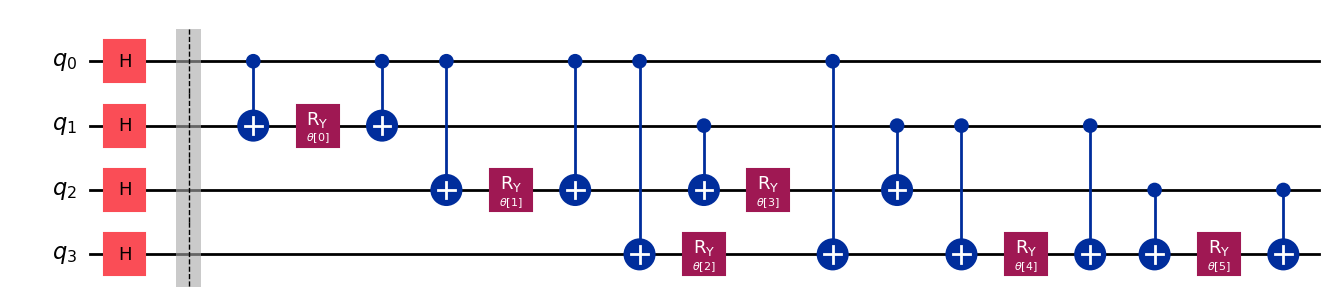

In [56]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Construct your favorite ansatz
ansatz = QuantumCircuit(graph.number_of_nodes())

# Use a uniform superposition as the initial state
ansatz.h(range(ansatz.num_qubits))
ansatz.barrier()

# Place entangling gates across qubit pairs that are connected in the graph
complete_graph = nx.complete_graph(graph.number_of_nodes())
params = ParameterVector(r"$\theta$", complete_graph.number_of_edges())
for theta, (u, v) in zip(params, complete_graph.edges):
    ansatz.cx(u, v)
    ansatz.ry(theta, v)
    ansatz.cx(u, v)
ansatz.draw("mpl")

We'll now use our ``ansatz`` to generate all the circuits that are needed to
compute the coefficients in the ODEs in Equation (5). We'll need $2n + 1$
circuits in total: $1$ to compute the expected value of $H_M$, and $2n$ to
compute its gradient with respect to the $n$ circuit parameters.

In [57]:
import math

# Set the current iteration parameters
# Play with this value! Make it whatever you'd like!!!
curr_params = [0] * ansatz.num_parameters

# Get the energy evaluation circuit
iter_circuits = list()
iter_circuits.append(ansatz.assign_parameters(curr_params))

# Get the 2n gradient circuits via the parameter shift rule
theta = ansatz.parameters
for k in range(ansatz.num_parameters):
    for pm in range(2):
        pm_shift = {symb: val + (-1)**pm * (j == k) * math.pi / 2 for j, (symb, val) in enumerate(zip(theta, curr_params))}
        iter_circuits.append(ansatz.assign_parameters(pm_shift))

# Sanity check
assert len(iter_circuits) == 2 * ansatz.num_parameters + 1, "Incorrect number of circuits!"

We can now execute the required ``iter_circuits`` using an IonQ QPU like IonQ
Forte! 

The code cell below illustrates how to run this calculation. Replace the
``"simulator"`` target by ``"forte-1"`` when you're ready to run on the real
QPU!

Make sure you've exported your IonQ API key as the ``IONQ_API_KEY`` environment
variable before running the next cell!

In [58]:
from ionq import Backend

# Choose your backend target
target = "simulator"

# Set up a backend object and execute your circuits!
backend = Backend(target)
job = backend.run(iter_circuits, shots=1_000, name="QITE iteration")

# Get the results
counts = job.results()

ImportError: cannot import name 'Backend' from 'ionq' (unknown location)

With the circuit counts in hand, we can run some post-processing classical code
to set up and solve the ODEs described in Equation (5). 

In this demo, we've used optimized parameters from a previous run. So we can
retrieve varQITE's top solution candidates from the counts of the zeroth circuit.

In [ ]:
from qiskit_optimization.applications import Maxcut

top_candidates = sorted(counts, key=lambda bitstring: counts[bitstring], reverse=True)

# Draw the best candidate
Maxcut(graph).draw(top_candidates[0])